# SPGEN
### Vehicle speed profile generator
<br>
The code is an example to show how to use the speed profiles generator. The architecture of the model is based on LSTMs.
All model's and training's details can be found in our paper : 
<br>
A. Dib, A. Sciarretta, and M. Balac, “A two-stage deep learning based approach for predicting instantaneous vehicle speed profiles on road networks,” in 2023 IEEE 26th International Conference on Intelligent Transportation Systems (ITSC). IEEE, 2023, pp. 1–7, to be published

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SPGen import SPGen
import tensorflow as tf

2024-02-05 13:52:42.159548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:52:43.116729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-05 13:52:43.116859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-05 13:52:43.116871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Loading the dataframe that contains road features and average speeds per link

In [2]:
df = pd.read_pickle("test_dataframe.pkl")

Each feature is a list, that contains the features of the sequence of links on which the vehicle passed. Moreover, "FC_1", "FC_2", ... Are functionnal classes and should be one hot vectors. "TL", "STOP", ... are coded with the same convention. One hot vectors are arrays with 1 if the element "i" exists otherwise 0.

All velocities in [km/h]
<br>
Slope in [grad]

Each list should be a numpy array (not a python list):

In [3]:
df = df.applymap(lambda x: np.array(x) if type(x)==list else x)

# Profiles Generation

Set explicitly TensorFlow to use CPU (check your environment if you wanna use your GPU, cause this may result in some errors)

Load the generator & Generate some profiles:  
  
REMARK: When generating speed profiles, a filter is used in order to limit the accelerations, you can impliment such a filter in the second stage, or change it. savgol_filter seems to be better for long trips, because we noticed some high frequency variations in the speed, espicially in long highways, which could introduces higher emissions.

In [4]:
in_velocity = df.gpsVelocity_res10.apply(lambda x: x[0][0]).to_numpy()

In [5]:
with tf.device("CPU"):
    profiles_generator = SPGen.SPGen()
    speed_profiles = profiles_generator.generate_speed_profiles_from_pandas(df, in_velocity = in_velocity)

2024-02-05 13:52:45.341076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:52:46.940868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29574 MB memory:  -> device: 0, name: NVIDIA Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-02-05 13:52:46.942544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30485 MB memory:  -> device: 1, name: NVIDIA Quadro GV100, pci bus id: 0000:d8:00.0, compute capability: 7.0


Second stage Inference : 100%|██████████| 11/11 [00:01<00:00,  6.76it/s]

# Plot the generated profiles

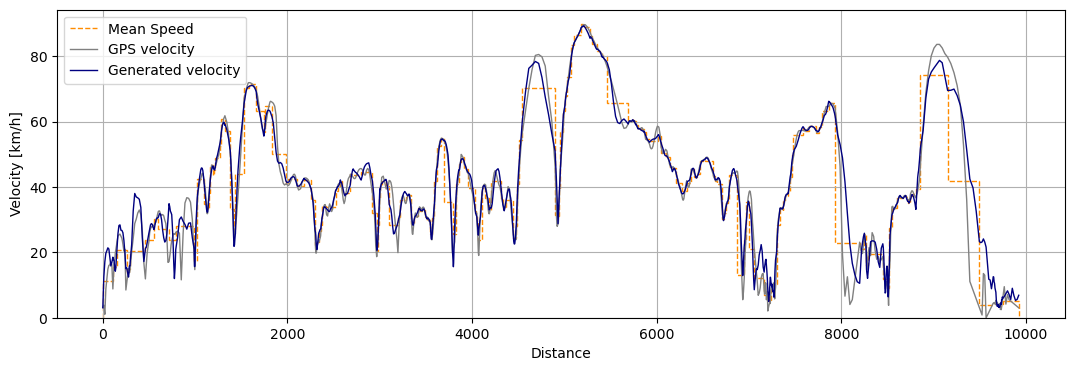

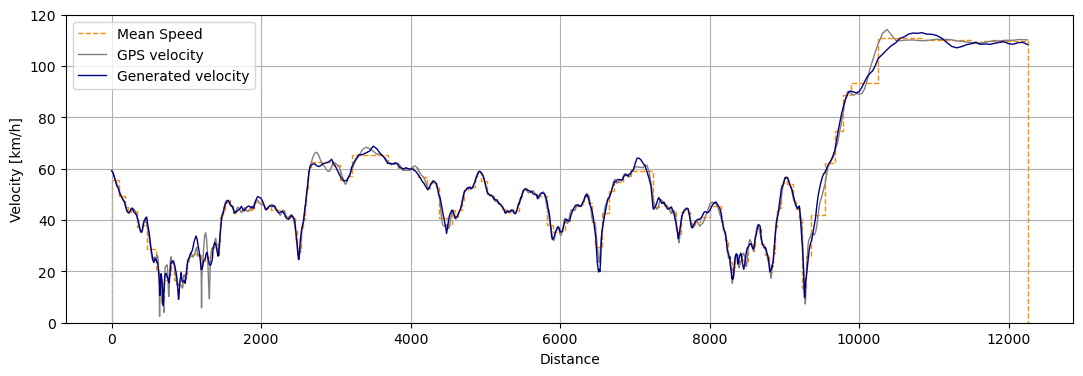

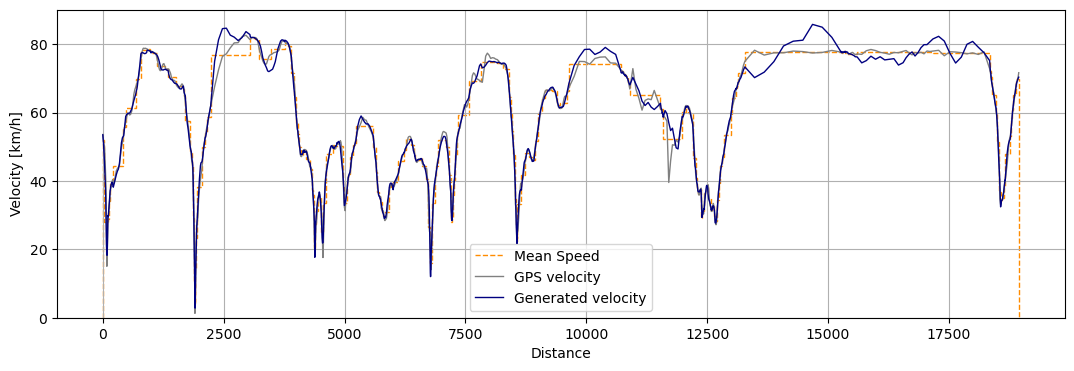

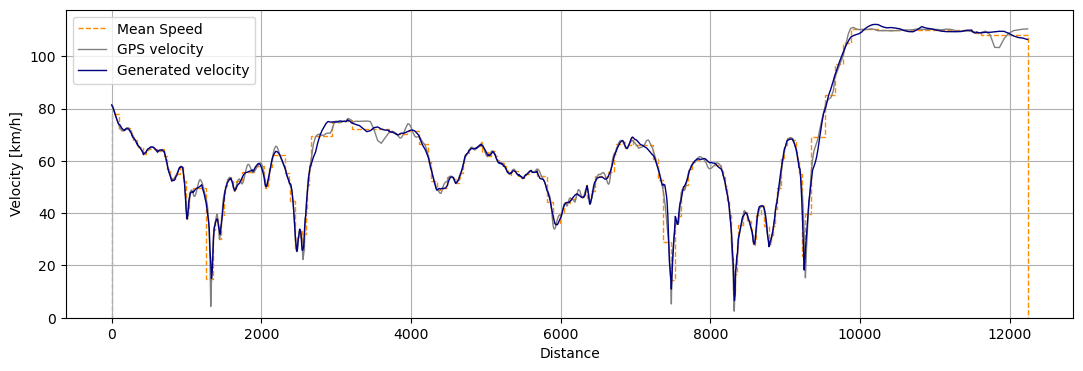

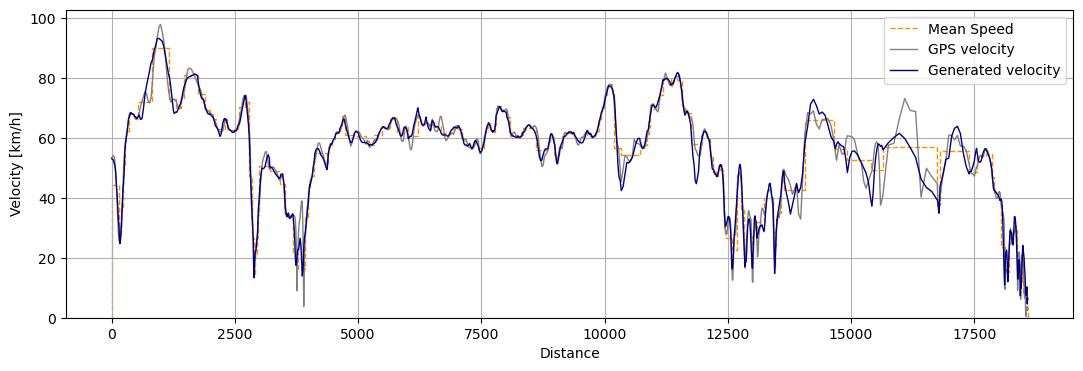

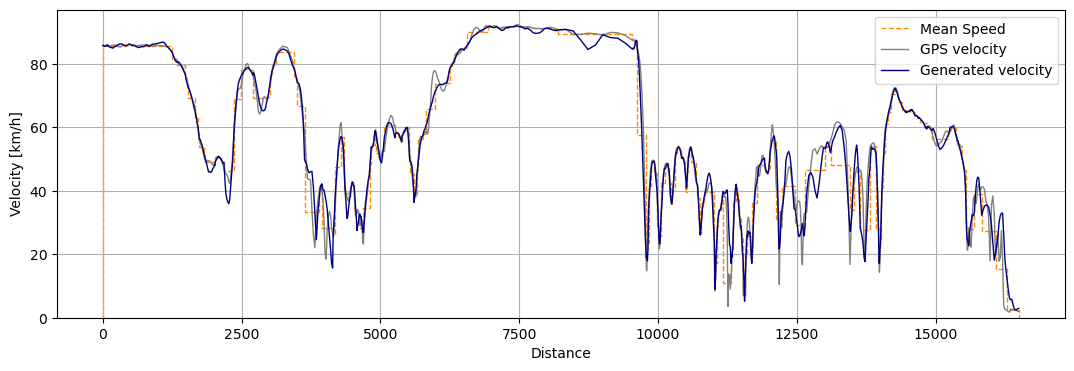

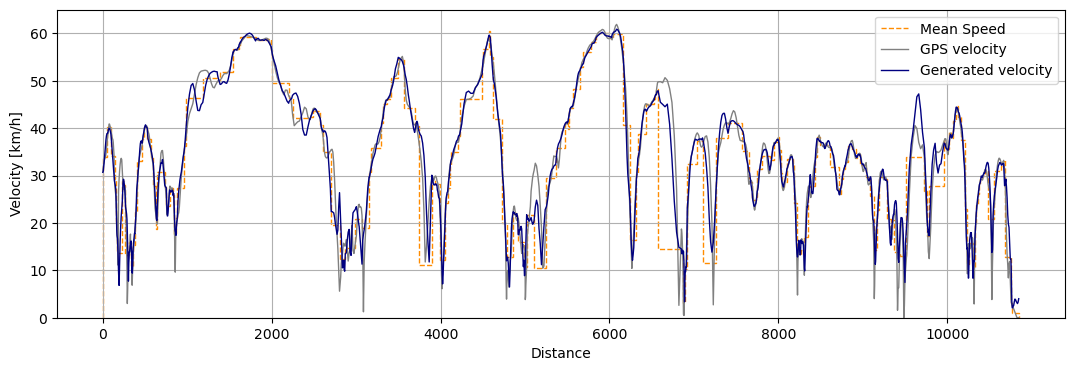

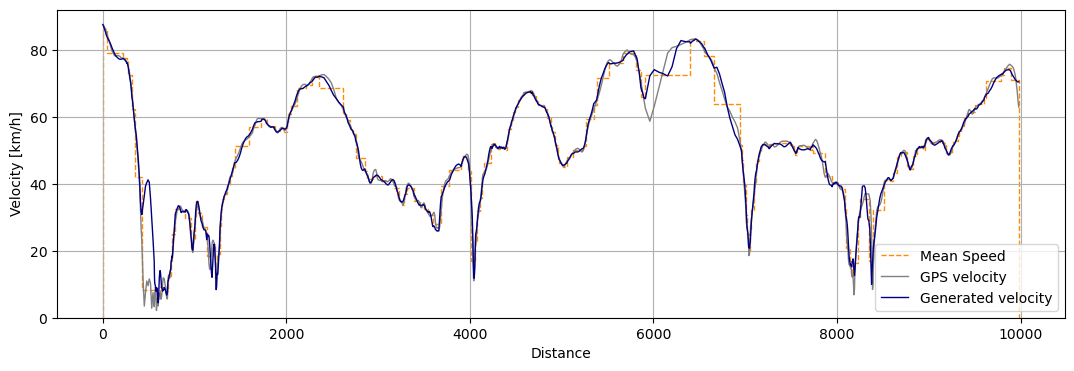

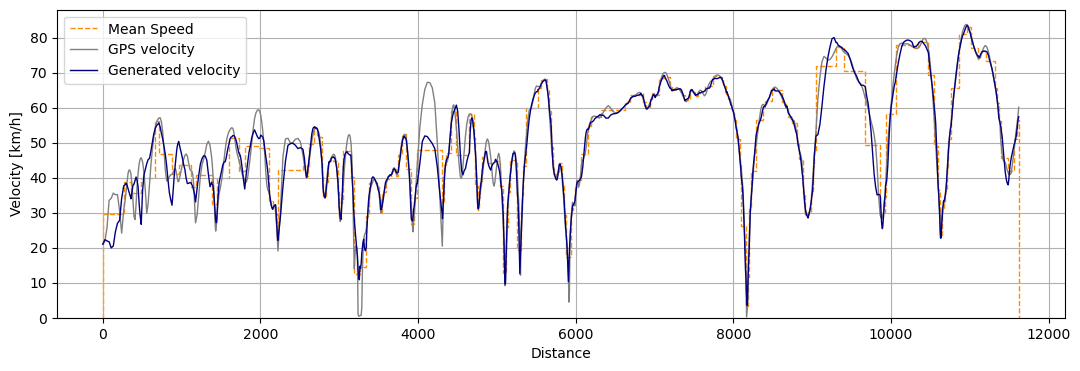

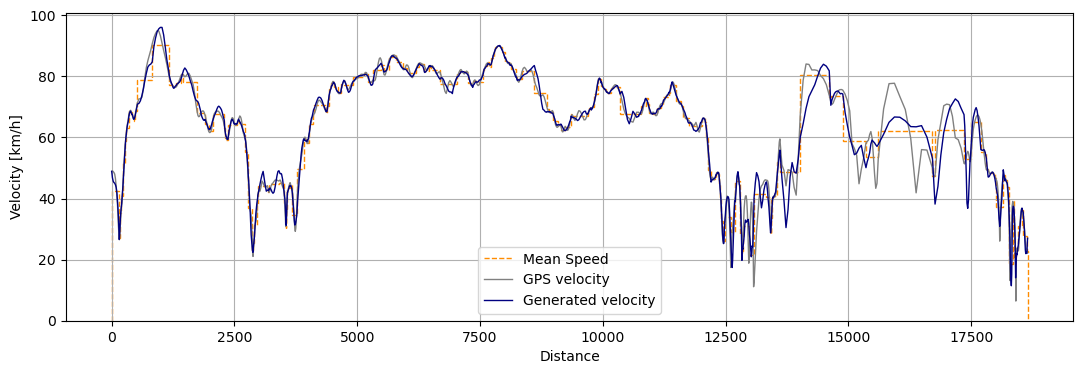

In [6]:
for i in range(10):
    plt.subplots(figsize=(13,4))
    plt.stairs(speed_profiles.MeanSpeed.iloc[i],np.cumsum([0,*speed_profiles.linkLength.iloc[i]]), label = "Mean Speed", linewidth=1, linestyle='--', color = "darkorange")
    plt.plot(speed_profiles.positions.iloc[i], speed_profiles.gpsProfiles.iloc[i], label="GPS velocity", linewidth=1, color="gray")
    plt.plot(speed_profiles.positions.iloc[i], speed_profiles.speed.iloc[i], label="Generated velocity", linewidth=1, color="navy")
    plt.grid()
    plt.xlabel("Distance")
    plt.ylabel("Velocity [km/h]")
    plt.legend()
    plt.show()